In [1]:
import getpass
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import scipy.ndimage

In [2]:
train_list = pd.read_csv('../dataset/train_filenames.csv', header=None)
test_list = pd.read_csv('../dataset/test_filenames.csv', header=None)
val_list = pd.read_csv('../dataset/val_filenames.csv', header=None)

In [3]:
train_sr = '../dataset/Down_sampled/Train/'
test_sr = '../dataset/Down_sampled/Test/'
val_sr = '../dataset/Down_sampled/Val/'

hr = "../dataset/row_col_trim/"

In [4]:
class SR_Data(Dataset):
    
    def __init__(self, sr_folder, hr_folder, file_list):
        self.sr_folder = sr_folder
        self.hr_folder = hr_folder
        self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        set_of_transforms = transforms.Compose([
        transforms.ToTensor()
        ])
        return set_of_transforms(Image.open(self.sr_folder+str(self.file_list[idx])).convert('RGB')), set_of_transforms(Image.open(self.hr_folder+str(self.file_list[idx])).convert('RGB'))

In [5]:
train_data = SR_Data(train_sr, hr, train_list[0])
test_data = SR_Data(test_sr, hr, test_list[0])
val_data = SR_Data(val_sr, hr, val_list[0])

print(len(train_data))
print(len(test_data))
print(len(val_data))

2000
250
250


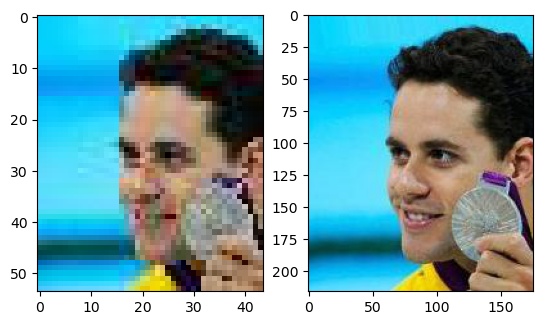

In [8]:
ex = train_data[1500]
img = np.transpose(ex[0].cpu().numpy(), (1, 2, 0))
img = (img)*255
img = img.astype(np.uint8)

img1 = np.transpose(ex[1].cpu().numpy(), (1, 2, 0))
img1 = (img1)*255
img1 = img1.astype(np.uint8)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(img1)
plt.show()

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convolution_layer_0 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 9, stride = 1, padding = 4)
        self.prelu0 = nn.PReLU()
        self.rb_0 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_1 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_2 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_3 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_4 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.convolution_layer_1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.convolution_layer_2 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv_1 = nn.ConvTranspose2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1, stride =2)
        self.bn2 = nn.BatchNorm2d(256)
        self.prelu1 = nn.PReLU()

        self.convolution_layer_3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv_0 = nn.ConvTranspose2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1, stride =2)
        self.convolution_layer_4 = nn.Conv2d(in_channels = 256, out_channels = 3, kernel_size = 9, stride = 1, padding = 4)

        
    def forward(self, x):
        x = self.convolution_layer_0(x)
        x = self.prelu0(x)
        
        residual1 = x
        
        x = self.rb_0(x)
        x += residual1
        
        residual2 = x
        
        x = self.rb_1(x)
        
        x += residual2
        
        residual3 = x
        
        x = self.rb_2(x)
        
        x += residual3
        
        residual4 = x
        
        x = self.rb_3(x)
        
        x += residual4
        
        residual5 = x
        
        x = self.rb_4(x)
        
        x += residual5

        x = self.convolution_layer_1(x)
        x = self.bn1(x)
        
        x += residual1
        
        x = self.convolution_layer_2(x)
        
        x = self.trans_conv_1(x, output_size = [i * 2 for i in list((x.size()[2:4]))])
        x = self.bn2(x)
        x = self.prelu1(x)
        
        x = self.convolution_layer_3(x)
        x = self.trans_conv_0(x, output_size = [i * 2 for i in list((x.size()[2:4]))])
        
        x = self.convolution_layer_4(x)
        
        return x      

In [10]:
Gen = Generator()
Gen = Gen.cuda()

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(in_features = 40960, out_features= 1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features= 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)


In [13]:
class Generator_1(nn.Module):
    def __init__(self):
        super(Generator_1, self).__init__()
        self.convolution_layer_0 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5, stride = 1, padding = 2)
        self.prelu0 = nn.PReLU()
        self.rb_0 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_1 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_2 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_3 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.rb_4 =nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
        )
        self.convolution_layer_1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.convolution_layer_2 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.shuffle_1 = nn.PixelShuffle(2)
        self.prelu1 = nn.PReLU()        
        self.convolution_layer_3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.shuffle_2 = nn.PixelShuffle(2)
        self.convolution_layer_4 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 5, stride = 1, padding = 2)

        
    def forward(self, x):
        x = self.convolution_layer_0(x)
        x = self.prelu0(x)
        
        residual1 = x
        
        x = self.rb_0(x)
        x += residual1
        
        residual2 = x
        
        x = self.rb_1(x)
        
        x += residual2
        
        residual3 = x
        
        x = self.rb_2(x)
        
        x += residual3
        
        residual4 = x
        
        x = self.rb_3(x)
        
        x += residual4
        
        residual5 = x
        
        x = self.rb_4(x)
        
        x += residual5

        x = self.convolution_layer_1(x)
        x = self.bn1(x)
        
        x += residual1
        
        x = self.convolution_layer_2(x)
               
        x = self.shuffle_1(x)
        x = self.prelu1(x)
        x = self.convolution_layer_3(x)
        x = self.shuffle_2(x)
        
        x = self.convolution_layer_4(x)
        
        return x       

In [14]:
Gen1 = Generator_1()
Gen1 = Gen1.cuda()

In [15]:
Dis = Discriminator()
Dis = Dis.cuda()

In [17]:
model_path = "../Codes/Models/"

Gen.load_state_dict(torch.load(model_path+'Gen_vgg_3.pth'))
Gen1.load_state_dict(torch.load(model_path+'Shuffler_Gen_57.pth'))
Dis.load_state_dict(torch.load(model_path+'Dis_vgg_3.pth'))

<All keys matched successfully>

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 4, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 4, num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 4, num_workers = 8)

In [29]:
with torch.no_grad():


       
        c = 0
        for sr, hr in val_loader:
            if c == 50:
                sr_rel = sr.cuda()
                hr_rel = hr.cuda()
                print(hr_rel.size()[0])
                fk = Gen(sr_rel)
                fk_1 = Gen1(sr_rel)
            c = c + 1
        
        for x in range(hr_rel.size()[0]):
            
            f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

            img = np.transpose(hr_rel.cpu().numpy()[x,:,:,:], (1, 2, 0))
            img = (img)*255
            img = img.astype(np.uint8)
            ax1.imshow(img)
            ax1.set_title('Ground truth')
            ax1.grid(False)
            ax1.set_xticks([])
            ax1.set_yticks([])


            imgf = np.transpose(fk.cpu().numpy()[x,:,:,:], (1, 2, 0))
            imgf = (imgf)*255
            imgf = imgf.astype(np.uint8)
            ax4.imshow(imgf)
            ax4.set_title('SR with transpose convolution')
            ax4.grid(False)
            ax4.set_xticks([])
            ax4.set_yticks([])



            imgi = np.transpose(sr_rel.cpu().numpy()[x,:,:,:], (1, 2, 0))
            imgi = (imgi)*255
            imgi = imgi.astype(np.uint8)


            ex = val_data[x+16*500]
            imbc = np.transpose(ex[0].cpu().numpy(), (1, 2, 0))
            imbc = (imbc)*255
            imbc = imbc.astype(np.uint8)
            im = Image.fromarray(imbc, 'RGB')
            new_im = im.resize((176,216),Image.BICUBIC)
            np_im = np.array(new_im)
            ax3.imshow(np_im)
            ax3.set_title(' Bicubic Interpolation')
            ax3.grid(False)
            ax3.set_xticks([])
            ax3.set_yticks([])
            
            ax2.imshow(imgi)
            ax2.set_title('Input')
            ax2.grid(False)
            ax2.set_xticks([])
            ax2.set_yticks([])
            
            imgf = np.transpose(fk_1.cpu().numpy()[x,:,:,:], (1, 2, 0))
            imgf = (imgf)*255
            imgf = imgf.astype(np.uint8)
            ax5.imshow(imgf)
            ax5.set_title('SR with pixel shuffler')
            ax5.grid(False)
            ax5.set_xticks([])
            ax5.set_yticks([])
                       
            f.set_size_inches(18.5, 10.5)

        plt.show()

NameError: name 'hr_rel' is not defined

(176, 216)


/tmp/ipykernel_45094/3498893929.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  new_im = im.resize((176,216),Image.BICUBIC)


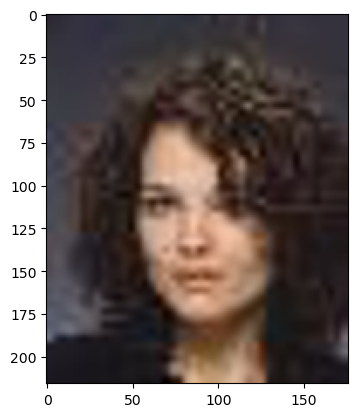

In [20]:
ex = val_data[0]
imbc = np.transpose(ex[0].cpu().numpy(), (1, 2, 0))
imbc = (imbc)*255
imbc = imbc.astype(np.uint8)
im = Image.fromarray(imbc, 'RGB')
new_im = im.resize((176,216),Image.BICUBIC)
print(new_im.size)
plt.imshow(new_im)
plt.show()